<h1>FCN_8s</h1>
<h3>201702052 이동헌</h3>

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

In [ ]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

from tensorflow import keras


In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (224, 224))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (224, 224))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (224, 224))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (224, 224))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

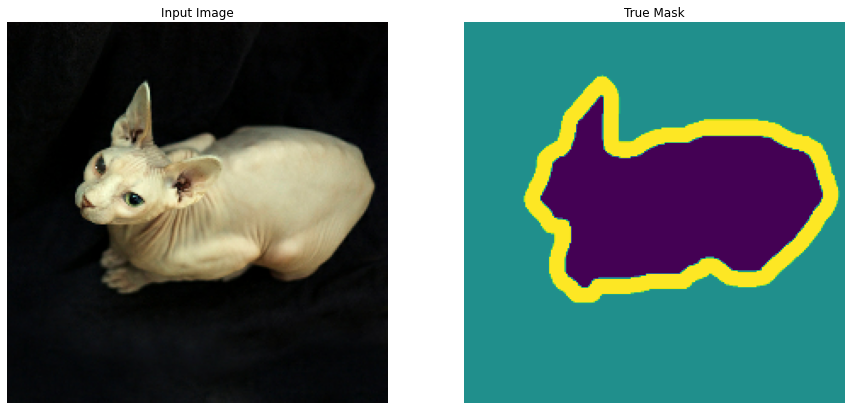

In [ ]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [ ]:
'''
TODO

FCN_8s 모델 구현하기
optimizer는 Adam을 사용할 것
'''

model_input = tf.keras.layers.Input(shape=(224, 224, 3))

x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(model_input)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)

x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)

x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
branch0 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)

x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(branch0)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
branch1 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)

x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(branch1)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)

x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = tf.keras.layers.Conv2D(filters=4096, kernel_size=(3,3), padding='same', activation='relu')(x)

x = tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu')(x)

upsampled0 = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(2,2), strides=(2,2), padding='valid')(x)

pulled0 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(branch1)
pulled0 = tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), padding='same')(pulled0)
added0 = tf.keras.layers.Add()([upsampled0, pulled0])

upsampled1 = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(2,2), strides=(2,2), padding='valid')(added0)

pulled1 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(branch0)
pulled1 = tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), padding='same')(pulled1)
added1 = tf.keras.layers.Add()([upsampled1, pulled1])

model_output = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(8,8), strides=(8,8), padding='valid')(added1)
model_output = tf.keras.layers.Conv2D(filters=3, kernel_size=(2,2), strides=(1,1), padding='same')(model_output)
model_output = tf.keras.layers.Conv2D(filters=3, kernel_size=(2,2), strides=(1,1), padding='same')(model_output)

fcn_model = keras.Model(model_input, model_output)

fcn_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
  
sample_image = tf.image.resize(sample_image, (224, 224))

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = fcn_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(fcn_model.predict(sample_image[tf.newaxis, ...]))])
    
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

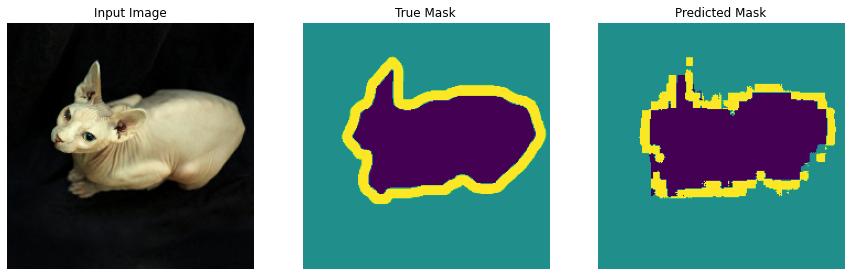


에포크 이후 예측 예시 20

57/57 [==============================] - 75s 1s/step - loss: 0.3125 - val_loss: 0.3539


In [ ]:
fcn_model.compile(optimizer='Adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = fcn_model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

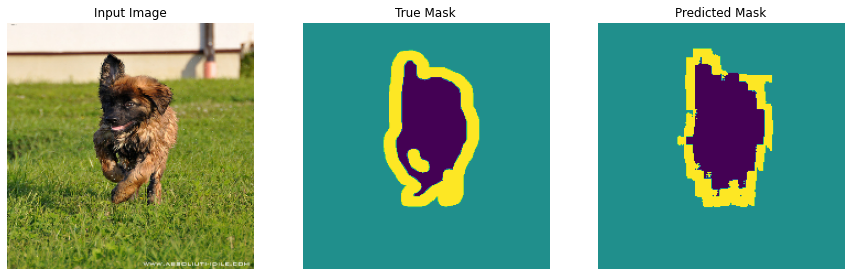

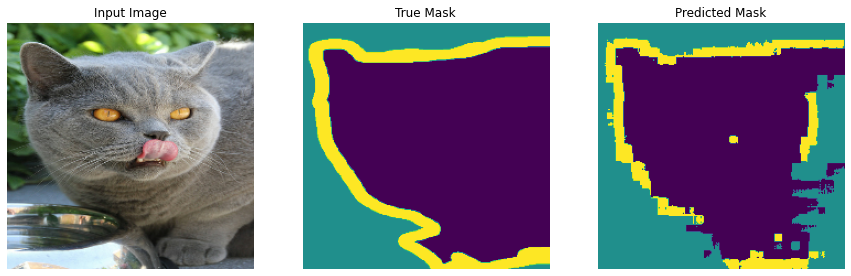

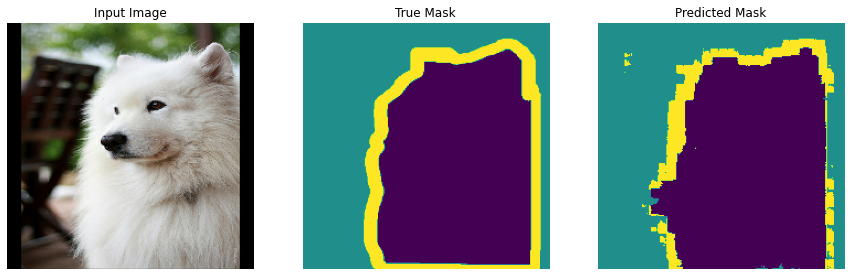

In [ ]:
show_predictions(test_dataset,3)